In [1]:
import pandas as pd
import optuna
import numpy as np
import logging
import copy
import os
import timeout_decorator

from IPython.display import display

import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay

from lightgbm import LGBMClassifier

from scipy.stats import ttest_ind

from sklearn import linear_model
from sklearn.svm import SVC

from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

from sklearn.preprocessing import StandardScaler

from pathlib import Path

Path(os.getcwd()).parents[2]

import sys

sys.path.append(Path(os.getcwd()).parents[2].as_posix())

from lib.validation import get_elasticnet_model, get_svm_linear_model, get_svm_rbf_model

logger = logging.getLogger()

optuna.logging.set_verbosity(optuna.logging.ERROR)

os.environ["PYTHONWARNINGS"] = "ignore::UserWarning"

In [2]:
# Set random seed so this part is reproducible
# https://www.random.org/ 2023-08-09
np.random.seed(3866)

In [4]:
#
# Train
#
trainX = pd.read_csv("../../../data/test/test_input/2023-08-14/synthetic-train-eff-0.5-ndiff-10-frac-0.1-2023-08-14.tsv",
                     sep='\t', 
                     index_col=0)

trainX = trainX.sample(frac=1.0, axis=1)

target_genes = trainX.var(axis=1).sort_values().tail(50).index.values

trainX = trainX.reindex(target_genes)

trainX = pd.DataFrame(StandardScaler().fit_transform(trainX.T).T,
                      index=trainX.index,
                      columns=trainX.columns)

trainY = np.array([0 if x.startswith("nonresponders") else 1 for x in trainX.columns])

#
# Test
#
testX = pd.read_csv("../../../data/test/test_input/2023-08-14/synthetic-test-eff-0.5-ndiff-10-frac-0.1-2023-08-14.tsv",
                    sep='\t', 
                    index_col=0)

testX = testX.sample(frac=1.0, axis=1)

testX = testX.reindex(target_genes)

testX = pd.DataFrame(StandardScaler().fit_transform(testX.T).T,
                     index=testX.index,
                     columns=testX.columns)

testY = np.array([0 if x.startswith("nonresponders") else 1 for x in testX.columns])

# Elastic Net

In [5]:
# Elastic Net
elastic_net_model, elastic_net_model_features, elastic_net_model_best_value, elastic_net_model_params = get_elasticnet_model(trainX.values.T, trainY, n_trials=100)

In [6]:
# Elastic Net Best Value
elastic_net_model_best_value

0.33333333333333326

In [7]:
# Elastic Net Of of Sample Prediction
X_test = testX.values.T
_X_test = X_test[:, elastic_net_model_features]

elastic_net_test_yhat = elastic_net_model.predict(_X_test)
f1_score(testY, elastic_net_test_yhat)

0.1592920353982301

# RBF SVM

In [8]:
rbf_svm_model, rbf_svm_model_features, rbf_svm_model_best_value, rbf_svm_model_params = get_svm_rbf_model(trainX.values.T, trainY, n_trials=100)

In [9]:
rbf_svm_model_best_value

0.28571428571428575

In [10]:
# Elastic Net Of of Sample Prediction
X_test = testX.values.T
_X_test = X_test[:, rbf_svm_model_features]

rbf_svm_test_yhat = rbf_svm_model.predict(_X_test)
f1_score(testY, rbf_svm_test_yhat)

0.15094339622641512

# Linear SVM

In [11]:
linear_svm_model, linear_svm_model_features, linear_svm_model_best_value, linear_svm_model_params = get_svm_linear_model(trainX.values.T, trainY, n_trials=100)

In [12]:
linear_svm_model_best_value

0.25396825396825395

In [13]:
# Elastic Net Of of Sample Prediction
X_test = testX.values.T
_X_test = X_test[:, linear_svm_model_features]

linear_svm_test_yhat = linear_svm_model.predict(_X_test)
f1_score(testY, linear_svm_test_yhat)

0.22222222222222218

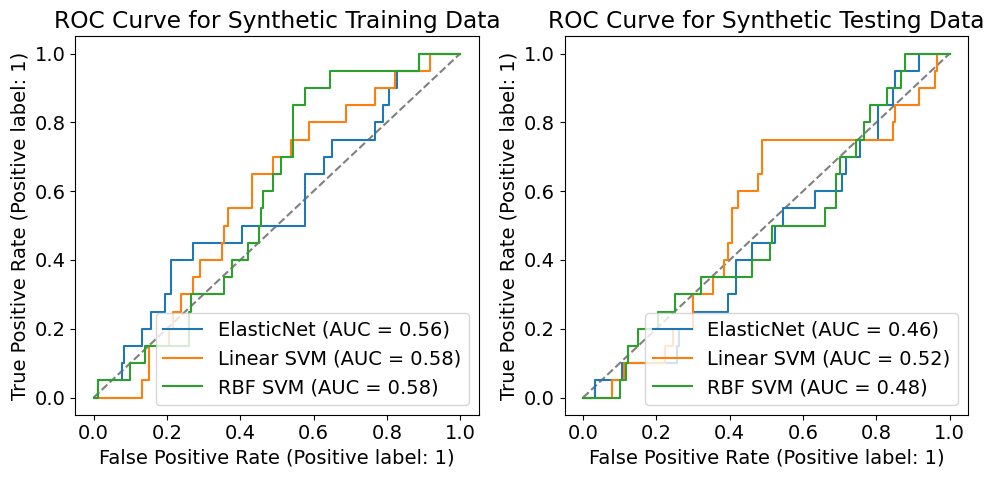

In [19]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(np.linspace(0, 1.0, 10), np.linspace(0.0, 1.0, 10), linestyle='--', color="gray")
axes[1].plot(np.linspace(0, 1.0, 10), np.linspace(0.0, 1.0, 10), linestyle='--', color="gray")

for name, model, _features in [("ElasticNet", elastic_net_model, elastic_net_model_features), 
                              ("Linear SVM", linear_svm_model, linear_svm_model_features), 
                              ("RBF SVM", rbf_svm_model, rbf_svm_model_features)]:
    
    X_train = trainX.values.T
    _X_train = X_train[:, _features]

    RocCurveDisplay.from_estimator(model, 
                                   _X_train, 
                                   trainY, 
                                   name=name,
                                   ax=axes[0])
    
    X_test = testX.values.T
    _X_test = X_test[:, _features]

    RocCurveDisplay.from_estimator(model, 
                                   _X_test, 
                                   testY, 
                                   name=name,
                                   ax=axes[1])

axes[0].set_title("ROC Curve for Synthetic Training Data")
axes[1].set_title("ROC Curve for Synthetic Testing Data")

plt.tight_layout()


plt.savefig("../../../figures/synthetic/synthetic-top-var-ml-prediction-roc-curve-plots.svg", 
            format='svg', 
            bbox_inches='tight')